In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
IMAGES_PATH = "/content/drive/MyDrive/Frontal Images"
IMAGE_SIZE = (299, 299)
VOCAB_SIZE = 3000
# SEQ_LENGTH = 20
SEQ_LENGTH = 60
EMBED_DIM = 512

# Number of self-attention heads
NUM_HEADS = 2
FF_DIM = 512

BATCH_SIZE = 64
EPOCHS = 60
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
import pandas as pd
from pprint import pprint
from IPython.display import clear_output
captions = pd.read_csv("/content/drive/MyDrive/vivthavn_eda/frontal_findings_impression_separated.csv")
captions['findings'] = captions.findings.apply(lambda x: "<start> " + x.strip() + " <end>")

c_text_data = captions.findings.values.tolist()
# captions

c_captions_mapping = {}
for index,row in captions.iterrows():
  print(index)
  # print(row.image_id)
  # print(row.findings_impression)
  fni = row.findings
  # fni = "<start> " + fni + " <end>"
  c_captions_mapping[row.image_id] = [fni]
  # break

clear_output()
pprint(c_captions_mapping)
del captions

Streaming output truncated to the last 5000 lines.
                                                                    'normal. '
                                                                    'no '
                                                                    'visible '
                                                                    'pneumothorax  '
                                                                    'focal '
                                                                    'airspace '
                                                                    'opacity  '
                                                                    'or '
                                                                    'pleural '
                                                                    'effusion '
                                                                    'is seen. '
                                                                    'no '
        

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
                                                                   'alveolar '
                                                                   'consolidation  '
                                                                   'no '
                                                                   'definite '
                                                                   'pleural '
                                                                   'effusion '
                                                                   'seen. no '
                                                                   'typical '
                                                                   'findings '
                                                                   'of '
                                                                   'pulmonary '
                                                                   'edema. no '
       

In [56]:
# def load_captions_data(filename):

#     with open(filename) as caption_file:
#         caption_data = caption_file.readlines()
#         caption_mapping = {}
#         text_data = []

#         for line in caption_data:
#             line = line.rstrip("\n")
#             img_name, caption = line.split("\t")
#             # Each image is repeated five times for the five different captions. Each
#             # image name has a prefix `#(caption_number)`
#             img_name = img_name.split("#")[0]
#             img_name = os.path.join(IMAGES_PATH, img_name.strip())

#             if img_name.endswith("jpg"):
#                 # We will add a start and an end token to each caption
#                 caption = "<start> " + caption.strip() + " <end>"
#                 text_data.append(caption)

#                 if img_name in caption_mapping:
#                     caption_mapping[img_name].append(caption)
#                 else:
#                     caption_mapping[img_name] = [caption]

#         return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)
    

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
#captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

captions_mapping = c_captions_mapping
text_data = c_text_data

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)

print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  2347
Number of validation samples:  587


In [57]:

def valid_test_split(caption_data, val_size=0.7, shuffle=True):

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    val_size = int(len(caption_data) * val_size)
    

    test_data = {
        img_name: caption_data[img_name] for img_name in all_images[:val_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[val_size:]
    }

    # 4. Return the splits
    return test_data, validation_data

In [58]:
test_data, valid_data_new = valid_test_split(valid_data)

In [59]:
test_data

{'/content/drive/MyDrive/Frontal Images/CXR1000_IM-0003-1001.png': ['<start> there is  increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. the cardiac silhouette is within normal limits.  opacity in the left midlung overlying the posterior left  th rib may represent focal airspace disease. no pleural effusion or pneumothorax. no acute bone abnormality. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR1000_IM-0003-3001.png': ['<start> there is  increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. the cardiac silhouette is within normal limits.  opacity in the left midlung overlying the posterior left  th rib may represent focal airspace disease. no pleural effusion or pneumothorax. no acute bone abnormality. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR1005_IM-0006-1001.png': ['<start> cardiac and mediastinal contours are within normal 

In [6]:
text_data

['<start> heart size  mediastinal contour  and pulmonary vascularity are within normal limits. minimal streaky atelectasis the left lung base. no focal consolidation  suspicious pulmonary opacity  large pleural effusion  or pneumothorax is identified. thoracic spondylosis. <end>',
 '<start> heart size is enlarged  pulmonary vascularity within normal limits. no visible pneumothorax .  right pleural effusion blunting posterior costophrenic . there is a   of subsegmental atelectasis of the left lung base. there is  alveolar airspace disease in the medial right lung base. multilevel degenerative disease of the visualized portions of the thoracolumbar spine. <end>',
 '<start> heart size and mediastinal contours appear within normal limits. pulmonary vascularity is within normal limits. no focal consolidation  suspicious pulmonary opacity  pneumothorax or definite pleural effusion. visualized osseous structures appear intact. <end>',
 '<start> the heart and mediastinal silhouettes are within

In [7]:
train_data

{'/content/drive/MyDrive/Frontal Images/CXR100_IM-0002-1001.png': ['<start> both lungs are clear and expanded. heart and mediastinum normal. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR2659_IM-1140-1001.png': ['<start> no focal lung consolidation. no pneumothorax or large pleural effusion. heart size and pulmonary vascularity are within normal limits. osseous structures are grossly intact. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR1980_IM-0637-1001.png': ['<start> the lungs are clear bilaterally. specifically  no evidence of focal consolidation  pneumothorax  or pleural effusion.. cardio mediastinal silhouette is unremarkable. visualized osseous structures of the thorax are without acute abnormality. <end>'],
 '/content/drive/MyDrive/Frontal Images/CXR2494_IM-1020-1001.png': ['<start> heart size is mildly enlarged. the pulmonary  and mediastinum are within normal limits. there is no pleural effusion or pneumothorax. there is no focal air space opacity to suggest a pne

In [8]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

In [39]:
def read_image(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def make_dataset(images, captions):
    img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
        read_image, num_parallel_calls=AUTOTUNE
    )
    cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
        vectorization, num_parallel_calls=AUTOTUNE
    )
    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
valid_dataset = make_dataset(list(valid_data_new.keys()), list(valid_data_new.values()))
test_dataset = make_dataset(list(test_data.keys()), list(test_data.values()))

In [40]:
list(train_data.values())

[['<start> heart size is upper limits of normal but stable. mediastinal contours are within normal limits.. chronically increased interstitial markings without focal airspace consolidation  pleural effusion  pneumothorax. degenerative changes of the spine. <end>'],
 ['<start> the heart size and pulmonary vascularity appear within normal limits. the lungs are free of focal airspace disease. no pleural effusion or pneumothorax is seen. <end>'],
 ['<start> stable cardiomediastinal silhouette. pulmonary vascularity is within normal limits. lungs are expanded and clear airspace disease. negative for pneumothorax or pleural effusion. limited evaluation reveals the   to be grossly intact. <end>'],
 ['<start> there is stable  scarring or atelectasis in the left midlung. the lungs are otherwise grossly clear. the heart size is near the upper limits of normal. mediastinal silhouette is normal. there is no pneumothorax or pleural effusion.  t spine osteophytes are noted. <end>'],
 ['<start> the l

In [41]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, 60), dtype=tf.int64, name=None))>

In [42]:
def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3), include_top=False, weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, 1280))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = layers.Dense(embed_dim, activation="relu")
        self.layernorm_1 = layers.LayerNormalization()

    def call(self, inputs, training, mask=None):
        inputs = self.dense_proj(inputs)
        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=None
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        return proj_input


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        
        self.dense_proj = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim)]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
      

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM, sequence_length=SEQ_LENGTH, vocab_size=VOCAB_SIZE
        )
        self.out = layers.Dense(VOCAB_SIZE)
        self.dropout_1 = layers.Dropout(0.1)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)
        inputs = self.dropout_1(inputs, training=training)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=combined_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)


        proj_output = self.dense_proj(out_2)
        proj_out = self.layernorm_3(out_2 + proj_output)
        proj_out = self.dropout_2(proj_out, training=training)

        preds = self.out(proj_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=1,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_loss_and_acc(self, batch_data, training=True):
        batch_img, batch_seq = batch_data
        # print("batch_img: ", batch_img.shape)
        # print("batch_seq: ", batch_seq.shape)
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                # 3. Pass image embeddings to encoder
                encoder_out = self.encoder(img_embed, training=training)

                batch_seq_inp = batch_seq[:, i, :-1]
                batch_seq_true = batch_seq[:, i, 1:]
                # print("batch_seq_inp: ", batch_seq_inp.shape)
                # print("batch_seq_true: ", batch_seq_true.shape)

                # 4. Compute the mask for the input sequence
                mask = tf.math.not_equal(batch_seq_inp, 0)

                # 5. Pass the encoder outputs, sequence inputs along with
                # mask to the decoder
                batch_seq_pred = self.decoder(
                    batch_seq_inp, encoder_out, training=training, mask=mask
                )

                # 6. Calculate loss and accuracy
                loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
                acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

                # 7. Update the batch loss and batch accuracy
                batch_loss += loss
                batch_acc += acc

            # 8. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 9. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 10. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        return batch_loss, batch_acc / float(self.num_captions_per_image)

    def train_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        loss, acc = self._compute_loss_and_acc(batch_data, training=False)
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state(acc)
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(
    embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=NUM_HEADS
)
decoder = TransformerDecoderBlock(
    embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=NUM_HEADS
)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder
)

In [43]:
# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(), loss=cross_entropy)

# Fit the model
history = caption_model.fit(
    train_dataset, 
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/60
37/37 [==============================] - 35s 434ms/step - loss: 4.1019 - acc: 0.1561 - val_loss: 2.7795 - val_acc: 0.4411
Epoch 2/60
37/37 [==============================] - 22s 338ms/step - loss: 2.4341 - acc: 0.4655 - val_loss: 2.1363 - val_acc: 0.5219
Epoch 3/60
37/37 [==============================] - 22s 341ms/step - loss: 2.0620 - acc: 0.5368 - val_loss: 1.8133 - val_acc: 0.5761
Epoch 4/60
37/37 [==============================] - 24s 338ms/step - loss: 1.8264 - acc: 0.5753 - val_loss: 1.5847 - val_acc: 0.6123
Epoch 5/60
37/37 [==============================] - 22s 338ms/step - loss: 1.6621 - acc: 0.6073 - val_loss: 1.4306 - val_acc: 0.6355
Epoch 6/60
37/37 [==============================] - 22s 342ms/step - loss: 1.5218 - acc: 0.6275 - val_loss: 1.2766 - val_acc: 0.6667
Epoch 7/60
37/37 [==============================] - 22s 344ms/step - loss: 1.4107 - acc: 0.6560 - val_loss: 1.1415 - val_acc: 0.6952
Epoch 8/60
37/37 [==============================] - 23s 348ms/step - 

In [44]:
caption_model.evaluate(test_dataset)

7/7 [==============================] - 4s 402ms/step - loss: 2.6671 - acc: 0.6345


[2.667107105255127, 0.6375331282615662]

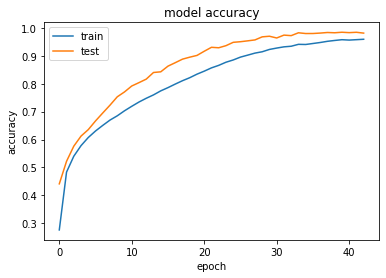

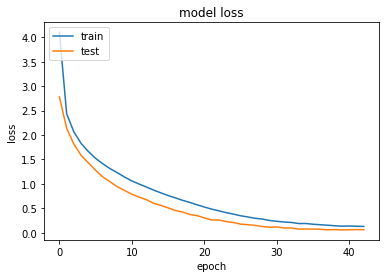

In [45]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [54]:
#valid_data

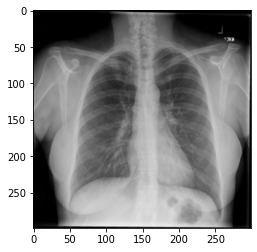

ACTUAL:  lungs are clear bilaterally. cardiac and mediastinal silhouettes are normal. pulmonary vasculature is normal. no pneumothorax or pleural effusion. no acute bony abnormality.
PREDICTED CAPTION: lungs are clear bilaterally cardiac and mediastinal silhouettes are normal pulmonary vasculature is normal no pneumothorax or pleural effusion no acute bony abnormality  soft wedge ribs vertebral is vertebral knee are vertebral vertebral which


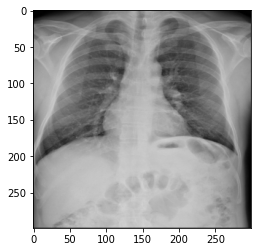

ACTUAL:  the trachea is midline. the cardiomediastinal silhouette is normal. the lungs are clear  without focal consolidation or effusion. there is no pneumothorax. the visualized bony structures reveal no acute abnormalities. lateral view reveals mild degenerative changes of the thoracic spine. no layering pleural effusion or pneumothorax seen on decubitus exam.
PREDICTED CAPTION: the lungs are clear the heart and pulmonary are normal the pleural spaces are clear and mediastinum are normal the skeletal structures are normal  wall is upper th through vertebral vertebral ribs versus ribs upper vertebral vertebral upper vertebral with


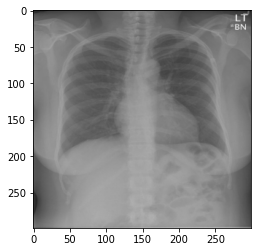

ACTUAL:  the heart and lungs have   in the interval. both lungs are clear and expanded. heart and mediastinum normal.
PREDICTED CAPTION: lungs are clear no focal consolidation effusion or pneumothorax normal heart size bony thorax and soft tissues grossly unremarkable  through soft subcutaneous could subcutaneous subcutaneous appear through demonstrated subcutaneous neck appear subcutaneous through no hyperexpanded from no no seen or seen cholecystectomy and seen well demonstrated appear free upper demonstrated abnormalities


In [60]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
test_images = list(test_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(test_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", test_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

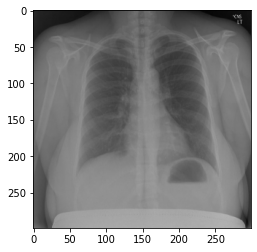

ACTUAL:  normal cardiomediastinal silhouette and hilar contours. the lungs are clear without focal area of consolidation  pleural effusion  or pneumothorax. findings compatible with prior granulomatous disease. the visualized   are intact without acute osseous abnormality.
PREDICTED CAPTION: the lungs are clear bilaterally specifically no evidence of focal consolidation pneumothorax or pleural effusion cardio mediastinal silhouette is unremarkable visualized osseous structures of the thorax are without acute abnormality  intramedullary noted without incidentally noted slight complicating unchanged biapical similar distal scattered without evidence of with intussusception limited distal loss of entirely degenerative


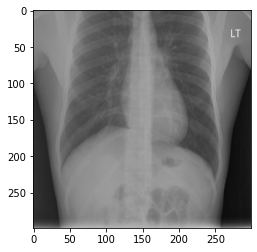

ACTUAL:  lungs are clear bilaterally. there is no focal consolidation  pleural effusion  or pneumothoraces. cardiomediastinal silhouette is within normal limits.  are unremarkable.
PREDICTED CAPTION: the lungs are clear the cardiomediastinal silhouette is within normal limits no pneumothorax or pleural effusion  are are scoliosis old old shoulder spine degenerative shoulder noted junction shoulder junction wedge shoulder noted knee shoulder vertebral shoulder vertebral junction knee and degenerative shoulder vertebral vertebral shoulder vertebral shoulder


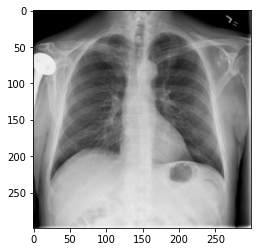

ACTUAL:  normal heart size. clear lungs. degenerative this disease within the spine. prosthetic right shoulder. possible  body in the axillary recess of the left shoulder. degenerative left glenohumeral osteoarthritis.
PREDICTED CAPTION: heart size normal lungs are clear degenerative change throughout the thoracic spine stable from prior examination no pleural effusions or pneumothoraces degenerative change  and wedge of wedge of knee osteophyte knee vertebral upper upper vertebral vertebral knee line upper vertebral upper vertebral upper vertebral


In [62]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(test_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", test_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

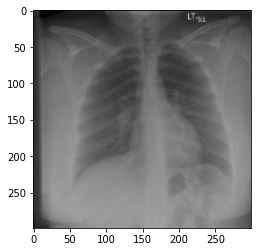

ACTUAL:  lungs are clear bilaterally. cardiac and mediastinal silhouettes are normal. pulmonary vasculature is normal. no pneumothorax or pleural effusion. no acute bony abnormality.
PREDICTED CAPTION: lungs are clear bilaterally cardiac and mediastinal silhouettes are normal pulmonary vasculature is normal no pneumothorax or pleural effusion no acute bony abnormality  vertebral wedge shoulder ribs degenerative vertebral vertebral shoulder vertebral junction knee vertebral vertebral shoulder shoulder


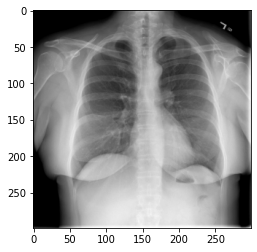

ACTUAL:  cardiac and mediastinal contours are within normal limits. prior granulomatous disease. the lungs are otherwise clear. thoracic spondylosis. bilateral breast prostheses with  calcification.
PREDICTED CAPTION: cardiac and mediastinal contours are within normal limits the lungs are otherwise clear thoracic spondylosis  calcification prior prior anterior osteophyte unchanged calcification of spondylosis prior of anterior of osteophyte cervical unchanged unchanged of unchanged unchanged osteophyte unchanged lumbar and osteophyte and thoracolumbar loss unchanged of unchanged thoracic disease


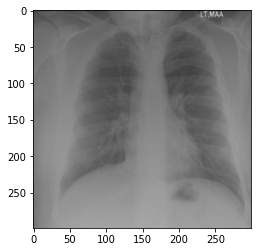

ACTUAL:  mediastinal contours are normal. heart size is within normal limits. lungs are clear. there is no pneumothorax or large pleural effusion.
PREDICTED CAPTION: lungs are clear no pleural effusions or pneumothoraces heart and mediastinum of normal size and contour degenerative changes in the spine  shoulder spine and stent limited junction wedge shoulder knee knee subcutaneous knee surgical vertebral vertebral knee upper vertebral upper vertebral vertebral vertebral


In [63]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(test_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", test_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

In [ ]:
caption_model.save_weights("/content/drive/MyDrive/Output_transform_new_impression")

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(test_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", test_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

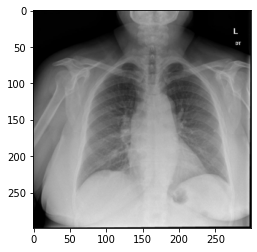

ACTUAL:  heart size within normal limits. no focal airspace disease. stable   mm lateral left midlung calcified granuloma. no pneumothorax or pleural effusion.
PREDICTED CAPTION: heart size within normal limits no focal airspace disease stable mm lateral left midlung calcified granuloma no pneumothorax or pleural effusion  bony also present also soft midfoot and abnormalities apex neck limit from also unchanged s also abdomen surgical dilated or knee and seen surgical right cannot abdomen cannot excluded excluded


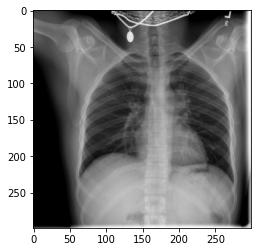

ACTUAL:  cardiac and mediastinal contours are within normal limits. the lungs are clear. bony structures are intact.
PREDICTED CAPTION: cardiac and mediastinal contours are within normal limits the lungs are clear bony structures are intact  vascular cervical enlargement vascular disease excluded no seen secondary edema no osteopenic pneumothorax demonstrated identified seen radiographic pneumothorax or identified abdomen bony knee imaging may or abnormalities would noted abdomen lesions


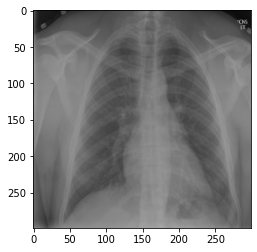

ACTUAL:  midline sternotomy  identified. heart size and cardiomediastinal silhouette are grossly normal. airspace opacity in posterior segment on the lateral view. osseous structures are grossly intact.
PREDICTED CAPTION: midline sternotomy identified heart size and cardiomediastinal silhouette are grossly normal airspace opacity in posterior segment on the lateral view osseous structures are grossly intact  and and mildly an age neck over present area density abdomen area present density density abdomen and on spine on an abdomen hip


In [21]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", valid_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", valid_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", valid_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", valid_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

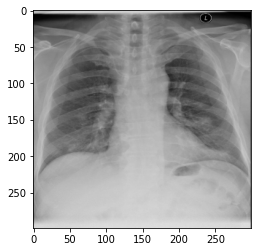

ACTUAL:  heart size and pulmonary vascularity appear within normal limits. right picc line is in . the tip has moved into the left innominate vein. there has been interval development of several ill defined focal opacities in the left and right mid lung zones. no pneumothorax or pleural effusion is seen.
PREDICTED CAPTION: heart size and pulmonary vascularity appear within normal limits right picc line is in the tip has moved into the left innominate vein there has been interval development of several ill defined focal opacities in the left and right mid lung zones no pneumothorax or pleural effusion is seen  fluid right is the


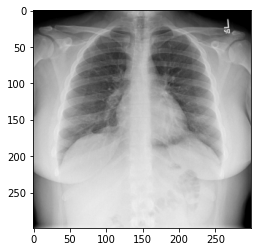

ACTUAL:  pa and lateral radiograph the chest demonstrate stable cardiomediastinal silhouette. no focal consolidation  large pleural effusion  or pneumothorax is identified. evidence of prior granulomatous disease. visualized osseous structures appear intact.
PREDICTED CAPTION: pa and lateral radiograph the chest demonstrate stable cardiomediastinal silhouette no focal consolidation large pleural effusion or pneumothorax is identified evidence of prior granulomatous disease visualized osseous structures appear intact  acute upper reside neck abdomen rectum surgical abdomen fracture dilated spine joint indicate ectatic dislocations region pathologic myeloma hip


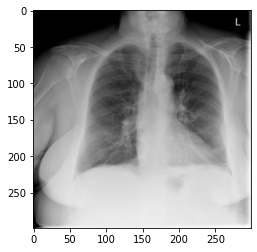

ACTUAL:  cardiac silhouette and pulmonary vascularity are normal. there is mild bibasilar focal atelectasis. no evidence of pleural effusion or pneumothorax. minimal atherosclerotic changes are present in the thoracic aorta.
PREDICTED CAPTION: cardiac silhouette and pulmonary vascularity are normal there is mild bibasilar focal atelectasis no evidence of pleural effusion or pneumothorax minimal atherosclerotic changes are present in the thoracic aorta  noted deformity secondary as region measures proximal of abdomen vascular t right spine opacity a limited indicate right t osteophytes t or


In [25]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", valid_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", valid_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", valid_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()

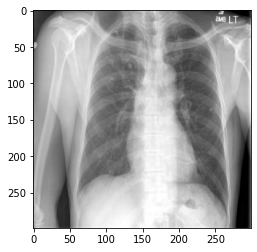

ACTUAL:  cardiomediastinal contours within normal limits. pulmonary vascularity is normal. there are scattered calcified testes bilaterally  consistent with prior granulomatous infection  stable. no  focal airspace consolidation. no pleural effusion  no pneumothorax. bony structures unremarkable.
PREDICTED CAPTION: cardiomediastinal contours within normal limits pulmonary vascularity is normal there are scattered calcified testes bilaterally consistent with prior granulomatous infection stable no focal airspace consolidation no pleural effusion no pneumothorax bony structures unremarkable  visualized unremarkable abdomen bony otherwise hemorrhage limited osteophytes abnormalities otherwise lesions


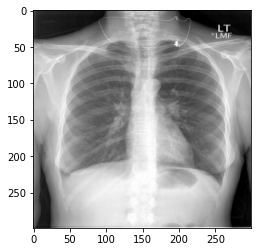

ACTUAL:  normal heart size. no focal air space consolidation  pneumothorax  pleural effusion  or pulmonary edema. no focal bony abnormality.
PREDICTED CAPTION: normal heart size no focal air space consolidation pneumothorax pleural effusion or pulmonary edema no focal bony abnormality  mild densities noted and of right nd posterior ribs which lesion bony which slightly thorax thorax mortise thorax grossly area injury midline acute abnormality reveals density indicate or abnormality opacities already versus


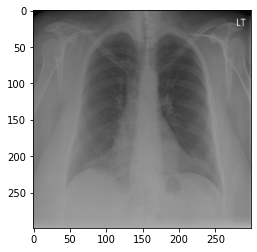

ACTUAL:  pa and lateral views the chest were obtained. the cardiomediastinal silhouette is normal in size and configuration. prominent bilateral pericardial fat pads. the lungs are well aerated. there is minimal patchy and  air space opacity within the lingula favored as atelectasis.
PREDICTED CAPTION: pa and lateral views the chest were obtained the cardiomediastinal silhouette is normal in size and configuration prominent bilateral pericardial fat pads the lungs are well aerated there is minimal patchy and air space opacity within the lingula favored as atelectasis  large pleural scarring left pneumothorax arthritic and visualized spine are air spine and or


In [30]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())


def generate_caption():
    # Select a random image from the validation dataset
    sample_img_path = np.random.choice(valid_images)

    # Read the image from the disk
    sample_img = read_image(sample_img_path)
    img = sample_img.numpy().astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

    print("ACTUAL: ", valid_data[sample_img_path][0].replace("<start> ", "").replace(" <end>", "").strip())
    print("PREDICTED CAPTION:", end=" ")
    print(decoded_caption.replace("<start> ", "").replace(" <end>", "").strip())
    
    


# Check predictions for a few samples
generate_caption()
generate_caption()
generate_caption()